# 번역가는 대화에도 능하다

좋은 번역을 만드는 데에는 무슨 능력이 필요할까요? 

가장 먼저 떠오르는 것은 역시 언어 능력이죠! 적어도 번역하고자 하는 언어는 통달해야 좋은 번역을 해낼 수 있을 것 같습니다.  
하지만 뛰어난 언어 실력만으로 가능할까요?

말하고 싶은 것은, 번역가들의 번역이 단순히 언어를 변환하는 과정에 그치는 것이 아니라 원문을 이해하고 그 이해를 바탕으로 새로운 글을 작문하여 탄생한다는 겁니다.

인공지능도 마찬가지입니다. 

번역을 잘 해낼 수 있는 모델은 곧 언어를 잘 이해할 수 있는 모델이기도 해요.  
그래서 번역을 잘하는 트랜스포머가 자언어 이해(Natural Language Understanding) 모델의 근간이 되는 거죠!.  
질문과 답변을 주고받는 것 또한 제법 높은 수준의 자연어 이해를 요구하는데, 이것도 잘 해낼 수 있을지...

번역 모델을 활용한 챗봇 만들기! 시작!

## 번역 데이터 준비

이번엔 접근성이 좋은 영어-스페인어 데이터를 사용하도록 하겠다.

### 라이브러리와 데이터 준비하기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
zip_path = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print('슝=3')

슝=3


In [4]:
file_path = os.path.dirname(zip_path)+"/spa-eng/spa.txt"
print(file_path)

with open(file_path, "r", encoding="UTF8") as f:
    spa_eng_sentences = f.read().splitlines()

spa_eng_sentences = list(set(spa_eng_sentences)) 
total_sentence_count = len(spa_eng_sentences)
print("Example:", total_sentence_count)

for sen in spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

C:\Users\ziipp\.keras\datasets/spa-eng/spa.txt
Example: 118964
>> She went blind.	Ella se quedó ciega.
>> We still have quite a few more miles to go before we get there.	Todavía tenemos que recorrer unos cuantos kilómetros más antes de llegar allí.
>> If you wish for peace, prepare for war.	Si queréis paz, preparaos para la guerra.
>> Tom couldn't possibly have done what you claimed he did.	No es posible que Tom pudiera hacer lo que tú alegabas que él hizo.
>> I assumed Tom was waiting for Mary.	Asumí que Tom estaba esperando a María.


#### 가벼운 전처리 함수 선언

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

print("슝=3")

슝=3


In [6]:
spa_eng_sentences = list(map(preprocess_sentence, spa_eng_sentences))

print('슝=3')

슝=3


이제 테스트에 사용할 데이터를 따로 떼어냅니다. 전체 데이터의 0.5% 정도를 테스트용으로 사용할게요.

In [7]:
test_sentence_count = total_sentence_count // 200
print("Test Size: ", test_sentence_count)
print("\n")

train_spa_eng_sentences = spa_eng_sentences[:-test_sentence_count]
test_spa_eng_sentences = spa_eng_sentences[-test_sentence_count:]
print("Train Example:", len(train_spa_eng_sentences))
for sen in train_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)
print("\n")
print("Test Example:", len(test_spa_eng_sentences))
for sen in test_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Test Size:  594


Train Example: 118370
>> she went blind.	ella se quedó ciega.
>> we still have quite a few more miles to go before we get there.	todavía tenemos que recorrer unos cuantos kilómetros más antes de llegar allí.
>> if you wish for peace, prepare for war.	si queréis paz, preparaos para la guerra.
>> tom couldn't possibly have done what you claimed he did.	no es posible que tom pudiera hacer lo que tú alegabas que él hizo.
>> i assumed tom was waiting for mary.	asumí que tom estaba esperando a maría.


Test Example: 594
>> tom had no say in the matter.	tom no tenía ni voz ni voto en el asunto.
>> we found a nail stuck in the tire.	encontramos un clavo clavado en el neumático.
>> you're not ready for this.	no estás listo para esto.
>> are you lying to me?	¿me estás mintiendo?
>> you've been very quiet.	estás muy callada.


한 줄에 포함되어 있는 영어와 스페인어를 분리해 줍니다.  
영어 문장과 스페인어 문장이 tab으로 연결되어 있으니 split('\t')을 사용하면 나눌 수 있겠네요. tab 이전이 영어, 이후가 스페인어 문장입니다.

In [8]:
def split_spa_eng_sentences(spa_eng_sentences):
    spa_sentences = []
    eng_sentences = []
    for spa_eng_sentence in tqdm(spa_eng_sentences):
        eng_sentence, spa_sentence = spa_eng_sentence.split('\t')
        spa_sentences.append(spa_sentence)
        eng_sentences.append(eng_sentence)
    return eng_sentences, spa_sentences

print('슝=3')

슝=3


학습 데이터와 테스트 데이터를 모두 나눠 줍니다

In [9]:
train_eng_sentences, train_spa_sentences = split_spa_eng_sentences(train_spa_eng_sentences)
print(len(train_eng_sentences))
print(train_eng_sentences[0])
print('\n')
print(len(train_spa_sentences))
print(train_spa_sentences[0])

  0%|          | 0/118370 [00:00<?, ?it/s]

118370
she went blind.


118370
ella se quedó ciega.


In [10]:
test_eng_sentences, test_spa_sentences = split_spa_eng_sentences(test_spa_eng_sentences)
print(len(test_eng_sentences))
print(test_eng_sentences[0])
print('\n')
print(len(test_spa_sentences))
print(test_spa_sentences[0])

  0%|          | 0/594 [00:00<?, ?it/s]

594
tom had no say in the matter.


594
tom no tenía ni voz ni voto en el asunto.


### 토큰화

이제 문장 데이터를 토큰화 해야 한다.  
<b>Sentencepiece</b> 기반의 토크나이저를 생성해 주는 generate_tokenizer() 함수를 정의하여 토크나이저를 얻어보자.  
https://github.com/google/sentencepiece 참고

In [13]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="spa-eng",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w', encoding="UTF8") as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

print("슝=3")

슝=3


이번엔 한-영 번역 때와 다르게, 두 언어가 단어 사전을 공유하도록 하겠습니다. 

영어와 스페인어 모두 알파벳으로 이뤄지는 데다가 같은 인도유럽어족이기 때문에 기대할 수 있는 효과가 많아요! 후에 챗봇을 만들 때에도 질문과 답변이 모두 한글로 이루어져 있기 때문에 Embedding 층을 공유하는 것이 성능에 도움이 됩니다.

단어 사전 수는 20,000으로 설정하겠습니다. 처리하는데 약간 시간이 걸립니다.

In [14]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_eng_sentences + train_spa_sentences, VOCAB_SIZE, 'spa-eng')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

True

위에서 두 언어 사이에 단어 사전을 공유하기로 하였으므로 Encoder와 Decoder의 전용 토크나이저를 만들지 않고,  
방금 만들어진 토크나이저를 두 언어 사이에서 공유하게 됩니다.

토크나이저가 준비되었으니 본격적으로 데이터를 토큰화하도록 하겠습니다. 

토큰화를 해주는 함수를 만들어 줍니다.

In [15]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus

print('슝=3')

슝=3


영어와 스페인어를 각각 토큰화 해줍니다. 훈련 데이터만 토큰화를 하고, 같은 토크나이저를 사용한다는 점에 주의하세요.

In [16]:
eng_corpus = make_corpus(train_eng_sentences, tokenizer)
spa_corpus = make_corpus(train_spa_sentences, tokenizer)

  0%|          | 0/118370 [00:00<?, ?it/s]

  0%|          | 0/118370 [00:00<?, ?it/s]

토큰화가 잘 되었는지 확인

In [17]:
print(train_eng_sentences[0])
print(eng_corpus[0])
print('\n')
print(train_spa_sentences[0])
print(spa_corpus[0])

she went blind.
[1, 45, 228, 2180, 0, 2]


ella se quedó ciega.
[1, 58, 33, 1069, 6270, 0, 2]


list 자료형도 단숨에 패딩 작업을 해주는 멋진 함수 pad_sequences() 를 기억하시죠?  
단숨에 데이터셋을 완성하도록 하겠습니다! 한 문장의 토큰 길이가 50이 되도록 설정했습니다.

In [18]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(spa_corpus, maxlen=MAX_LEN, padding='post')

print('슝=3')

슝=3


이제 모델 훈련에 사용될 수 있도록 영어와 스페인어 데이터를 묶어 배치 크기의 텐서로 만들어 줍니다. 

데이터 셋이 완성 되었어요!

In [19]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

print('슝=3')

슝=3


이제 모델을 만들러 가봅시다~!

## 번역 모델 만들기

### 트랜스포머 구현하기

생성된 데이터를 학습할 수 있는 멋진 트랜스포머(Transformer)를 구현하세요!

단, Encoder와 Decoder 각각의 Embedding과 출력층의 Linear, 총 3개의 레이어가 Weight를 공유할 수 있게 하세요!

하이퍼파라미터는 아래와 동일하게 정의합니다.

`transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)`

### Step 1. Positional Encoding

In [20]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
print("슝=3")

슝=3


### Step 2. mask 생성

In [21]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)
    return enc_mask, dec_enc_mask, dec_mask
print("슝=3")

슝=3


### Step 3. Multi-head Attention

In [22]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        
    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights
print("슝=3")

슝=3


### Step 4. Position-wise Feed Forward Network

In [23]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        
        return out
print("슝=3")

슝=3


### Step 5. Encoder Layer

In [24]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### Step 6. Decoder Layer

In [25]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):

        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
print("슝=3")

슝=3


### Step 7. Encoder

In [26]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns
print("슝=3")

슝=3


### Step 8. Decoder

In [27]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
            
        return out, dec_attns, dec_enc_attns
print("슝=3")

슝=3


### Step 9. Transformer 전체 모델 조립

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
print("슝=3")

슝=3


### Step 10. 모델 인스턴스 생성

In [29]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

print("슝=3")

슝=3


이제 학습을 시켜보자!!!

### Learning Rate Scheduler

In [30]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


### Learning Rate & Optimizer

In [31]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
                                        
print("슝=3")

슝=3


### Loss Function 정의

In [32]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
print("슝=3")

슝=3


### Train Step 정의

In [33]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  

    return loss, enc_attns, dec_attns, dec_enc_attns
print("슝=3")

슝=3


훈련 시키자!!!

In [34]:
# 훈련시키기
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

## 번역 성능 측정하기 (1) BLEU Score

https://en.wikipedia.org/wiki/BLEU 참고

### NLTK를 활용한 BLEU Score

NLTK는 Natural Language Tool Kit 의 준말로 이름부터 자연어 처리에 큰 도움이 될 것 같은 라이브러리입니다.😃  
nltk 가 BLEU Score를 지원하니 이를 활용하도록 합시다.

In [35]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


D:\Study\NotebookProjects\modoo-nlp\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Study\NotebookProjects\modoo-nlp\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU Score는 0~1 사이의 값을 가지지만, 100을 곱한 백분율 값으로 표기하는 경우도 많습니다. 

BLEU Score의 점수대별 해석에 대해서는 https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu 를 참고해 주세요.

BLEU Score가 50점을 넘는다는 것은 정말 멋진 번역을 생성했다는 의미예요.  
보통 논문에서 제시하는 BLEU Score는 20점에서 높으면 40점을 바라보는 정도거든요! 하지만 방금 나온 점수는 사실상 0점이라고 해야 하겠네요. 

그렇게까지 엉망진창인 번역이 된 것일까요?

BLEU Score의 정의로 돌아가 한번 따져봅시다. BLEU Score가 N-gram으로 점수를 측정한다는 것을 기억하실 거예요. 아래 수식을 기억하시죠?

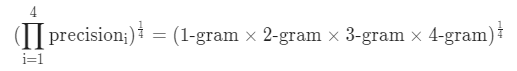

In [36]:
from IPython.display import Image
Image(filename='capture/17_bleu_score.png') 

1-gram부터 4-gram까지의 점수(Precision)를 모두 곱한 후, 루트를 두 번 씌우면 BLEU Score가 된답니다. 

진정 멋진 번역이라면, 모든 N-gram에 대해서 높은 점수를 얻었을 거예요. 

그렇다면 위에서 살펴본 예시에서는 각 N-gram이 점수를 얼마나 얻었는지 확인해 보도록 합시다.  
weights의 디폴트 값은 [0.25, 0.25, 0.25, 0.25]로 1-gram부터 4-gram까지의 점수에 가중치를 동일하게 주는 것이지만, 만약 이 값을 [1, 0, 0, 0]으로 바꿔주면 BLEU Score에 1-gram의 점수만 반영하게 됩니다.

In [37]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


0점에 가까운 BLEU Score가 나오는 원인을 알 수 있겠네요.  
바로 3-gram와 4-gram에서 거의 0점을 받았기 때문인데요, 위 예시에서 번역문 문장 중 어느 3-gram도 원문의 3-gram과 일치하는 것이 없기 때문입니다. 2-gram이 0.18이 나오는 것은 원문의 11개 2-gram 중에 2개만이 번역문에서 재현되었기 때문입니다.

### SmoothingFunction()으로 BLEU Score 보정하기

그래서 BLEU 계산시 특정 N-gram이 0점이 나와서 BLEU가 너무 커지거나 작아지는 쪽으로 왜곡되는 문제를 보완하기 위해 SmoothingFunction() 을 사용하고 있습니다. 

Smoothing 함수는 모든 Precision에 아주 작은 epsilon 값을 더해주는 역할을 하는데, 이로써 0점이 부여된 Precision도 완전한 0이 되지 않으니 점수를 1.0 으로 대체할 필요가 없어지죠. 즉 우리의 의도대로 점수가 계산되는 거예요.

진실된 BLEU Score를 확인하기 위해 어서 SmoothingFunction() 을 적용해 봅시다! 

아래 코드에서는 SmoothingFunction().method1을 사용해 보겠습니다.  
자신만의 Smoothing 함수를 구현해서 적용할 수도 있겠지만, nltk에서는 method0부터 method7까지를 이미 제공하고 있습니다.

In [38]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


SmoothingFunction()로 BLEU score를 보정한 결과, 새로운 BLEU 점수는 무려, 5점으로 올라갔습니다. 

거의 의미 없는 번역이라는 냉정한 평가를 받게 되는군요.😥

여기서 BLEU-4가 BLEU-3보다 조금이나마 점수가 높은 이유는 한 문장에서 발생하는 3-gram 쌍의 개수와 4-gram 쌍의 개수를 생각해 보면 이해할 수 있습니다. 각 Precision을 N-gram 개수로 나누는 부분에서 차이가 발생하는 것이죠.

### 트랜스포머 모델의 번역 성능 알아보기

위 예시를 조금만 응용하면 우리가 훈련한 모델이 얼마나 번역을 잘하는지 평가할 수 있습니다!.  
아까 0.5%의 데이터를 테스트셋으로 빼 둔 것을 기억하시죠? 테스트셋으로 모델의 BLEU Score를 측정하는 함수 eval_bleu() 를 구현해보도록 합시다!

먼저 번역기가 문장을 생성하도록 translate() 함수를 정의하겠습니다.

In [39]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("슝=3")

슝=3


다음으로 번역한 문장의 BLEU Score를 평가할 수 있도록 함수를 작성합니다.

우선 한 문장만 평가하는 eval_bleu_single을 만들어 봅시다.

In [40]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


테스트 데이터 중에 하나를 골라 평가해 봅시다.

In [41]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 1

eval_bleu_single(transformer, 
                 test_eng_sentences[test_idx], 
                 test_spa_sentences[test_idx], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  tom fixed everything.
Model Prediction:  ['tom', 'arregló', 'todo', 'el', 'mundo', 'lo', 'que', 'le', 'déndes', 'todo', 'el', 'mundo', 'lo', 'que', 'tom', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo', 'demás', 'lo']
Real:  ['tom', 'arregló', 'todo.']
Score: 0.008453



0.008453462482287115

이제 전체 테스트 데이터에 대해서 평가해 봅시다. eval_bleu_single을 이용해서 eval_bleu 함수를 작성합니다.

In [42]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("슝=3")

슝=3


평가해 봅니다.

In [43]:
eval_bleu(transformer, test_eng_sentences, test_spa_sentences, tokenizer, tokenizer, verbose=False)

  0%|          | 0/594 [00:00<?, ?it/s]

Num of Sample: 594
Total Score: 0.09803853530102441


## 번역 성능 측정하기 (2) Beam Search Decoder

이 멋진 평가 지표를 더 멋지게 사용하는 방법! 바로 모델의 생성 기법에 변화를 주는 것이죠. Greedy Decoding 대신 새로운 기법을 적용하면 우리 모델을 더 잘 평가할 수 있을 것 같네요!

Beam Search를 기억하나요? 예시로 활용했던 코드를 다시 한번 살펴보면,

In [44]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

print("슝=3")

슝=3


In [45]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


사실 이 예시는 Beam Search를 설명하는 데에는 더없이 적당하지만 실제로 모델이 문장을 생성하는 과정과는 거리가 멉니다.  
당장 모델이 문장을 생성하는 과정만 떠올려도 위의 prob_seq 처럼 확률을 정의할 수 없겠다는 생각이 머리를 스치죠.  
각 단어에 대한 확률은 prob_seq 처럼 한 번에 정의가 되지 않고 이전 스텝까지의 단어에 따라서 결정되기 때문입니다!

간단한 예시로, Beam Size가 2이고 Time-step이 2인 순간의 두 문장이 나는 밥을 , 나는 커피를 이라고 한다면 세 번째 단어로 먹는다 , 마신다 를 고려할 수 있습니다. 이때, 전자에서 마신다 에 할당하는 확률과 후자에서 마신다 에 할당하는 확률은 각각 이전 단어들인 나는 밥을 , 나는 커피를 에 따라서 결정되기 때문에 서로 독립적인 확률을 갖습니다. 예컨대 후자가 마신다 에 더 높은 확률을 할당할 것을 알 수 있죠! 위 소스에서처럼 "3번째 단어는 항상 [마신다: 0.3, 먹는다:0.5, ...] 의 확률을 가진다!" 라고는 할 수 없다는 겁니다.

따라서 Beam Search를 생성 기법으로 구현할 때에는 분기를 잘 나눠줘야 합니다.  
Beam Size가 5라고 가정하면 맨 첫 단어로 적합한 5개의 단어를 생성하고, 두 번째 단어로 각 첫 단어(5개 단어)에 대해 5순위까지 확률을 구하여 총 25개의 문장을 생성하죠. 그 25개의 문장들은 각 단어에 할당된 확률을 곱하여 구한 점수(존재 확률) 를 가지고 있으니 각각의 순위를 매길 수 있겠죠? 점수 상위 5개의 표본만 살아남아 세 번째 단어를 구할 자격을 얻게 됩니다.

위 과정을 반복하면 최종적으로 점수가 가장 높은 5개의 문장을 얻게 됩니다. 물론 Beam Size를 조절해 주면 그 수는 유동적으로 변할 거구요! 

다들 잘 이해하셨죠? 😃

### Beam Search Decoder 작성 및 평가하기

각 단어의 확률값을 계산하는 calc_prob()와 Beam Search를 기반으로 동작하는 beam_search_decoder() 를 구현하고 생성된 문장에 대해 BLEU Score를 출력하는 beam_bleu() 를 구현하세요!

편의에 따라서 두 기능을 하나의 함수에 구현해도 좋습니다!

In [46]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
            
    return tf.math.softmax(predictions, axis=-1)
print("슝=3")

슝=3


In [47]:
# beam_search_decoder() 구현
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred
print("슝=3")

슝=3


BLEU 계산 함수는 이전과 동일하게 사용할게요.

In [48]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

print('슝=3')

슝=3


마지막으로 beam_bleu함수를 만들어 주세요.

In [49]:
# beam_bleu() 구현
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
    return total_score / len(ids)
print("슝=3")

슝=3


In [50]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 2

ids = \
beam_search_decoder(test_eng_sentences[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_spa_sentences[test_idx], ids, tokenizer)
print(bleu)

Reference: ['la', 'herida', 'se', 'infectó.']
Candidate: ['la', 'herida', 'se', 'volvió', 'profesora', 'a', 'tiempo']
BLEU: 0.16348126556655487
Reference: ['la', 'herida', 'se', 'infectó.']
Candidate: ['la', 'herida', 'se', 'volvió', 'contra', 'a', 'tiempo']
BLEU: 0.16348126556655487
Reference: ['la', 'herida', 'se', 'infectó.']
Candidate: ['la', 'herida', 'se', 'volvió', 'profesora', 'a', 'fondo']
BLEU: 0.16348126556655487
Reference: ['la', 'herida', 'se', 'infectó.']
Candidate: ['la', 'herida', 'se', 'volvió', 'profesora', 'a', 'la']
BLEU: 0.16348126556655487
Reference: ['la', 'herida', 'se', 'infectó.']
Candidate: ['la', 'herida', 'se', 'volvió', 'paradero', 'a', 'tiempo']
BLEU: 0.16348126556655487
0.16348126556655487


## 데이터 부풀리기

이번 스텝에서는 Data Augmentation, 그중에서도 Embedding을 활용한 Lexical Substitution을 구현해 볼 거예요.  
gensim 라이브러리를 활용하면 어렵지 않게 해낼 수 있습니다!

gensim 에 사전 훈련된 Embedding 모델을 불러오는 것은 두 가지 방법이 있습니다.

- 직접 모델을 다운로드해 load 하는 방법
- gensim 이 자체적으로 지원하는 downloader 를 활용해 모델을 load 하는 방법

한국어는 gensim 에서 지원하지 않으므로 두 번째 방법을 사용할 수 없지만, 영어라면 얘기가 달라지죠!.  
아래 웹페이지의 Available data → Model 부분에서 공개된 모델의 종류를 확인할 수 있습니다.  
https://github.com/RaRe-Technologies/gensim-data

대표적으로 사용되는 Embedding 모델은 word2vec-google-news-300 이지만 용량이 커서 다운로드에 많은 시간이 소요되므로 이번 실습엔 적합하지 않습니다. 

우리는 적당한 사이즈의 모델인 glove-wiki-gigaword-300 을 사용할게요! 아래 소스를 실행해 사전 훈련된 Embedding 모델을 다운로드해 주세요.

In [51]:
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


불러온 모델은 아래와 같이 활용할 수 있습니다.

In [52]:
wv.most_similar("banana")

[('bananas', 0.6691170930862427),
 ('mango', 0.5804104208946228),
 ('pineapple', 0.5492372512817383),
 ('coconut', 0.5462778806686401),
 ('papaya', 0.541056752204895),
 ('fruit', 0.52181077003479),
 ('growers', 0.4877638816833496),
 ('nut', 0.48399588465690613),
 ('peanut', 0.48062023520469666),
 ('potato', 0.48061180114746094)]

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하면 그것으로 Lexical Substitution은 완성되겠죠? 

가볍게 확인해 봅시다!

In [53]:
sample_sentence = "you know ? all you need is attention ."
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: you know ? all you need is attention .
To: you know ? all you need is focus . 


### Lexical Substitution 구현하기

입력된 문장을 Embedding 유사도를 기반으로 Augmentation 하여 반환하는 lexical_sub() 를 구현하세요!

In [54]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

만들어진 함수를 사용해 볼까요? 시간이 오래 걸리니 우선 테스트 데이터의 Augmentation들을 만들어 봅시다. 약간 시간이 걸립니다. 

프로젝트에서는 학습 데이터로 Augmentation을 해야합니다~!

In [55]:
new_corpus = []

for old_src in tqdm(test_eng_sentences):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

  0%|          | 0/594 [00:00<?, ?it/s]

['tom had no say in the matter.', 'tom rate everything. ', 'tom fixed everything.', 'the wound became infected.', "don't you you the clock? ", "don't you see the clock?", 'someone broke of lock and stole my bike. ', 'someone broke the lock and stole my bike.', 'are they come here tomorrow? ', 'are they coming here tomorrow?']
